In [1]:
import pandas as pd

In [2]:
#!pip install lightgbm

In [3]:
#load data
segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

In [4]:
X.columns

Index(['product_description', 'loan_account_no', 'res_years_at_current_city',
       'age', 'down_payment_amount', 'total_income', 'occupation_type',
       'interest_rate', 'number_of_installments', 'loan_asset_cost',
       'res_years_at_current_address', 'gender', 'marital_status',
       'nature_of_business', 'years_in_occupation', 'monthly_income',
       'dp_ratio', 'D3_within12months', 'manufacturer_grp', 'channel_grp',
       'industry_grp', 'branch_grp', 'asset_model_grp', 'res_city_grp',
       'res_state_grp', 'res_resident_status_grp'],
      dtype='object')

In [5]:
#tuning lgb jied
def lgbc_model_builder3(boosting_type = 'gbdt',
        max_depth = -1,
        learning_rate = 0.1,
        min_split_gain = 0.0,
        num_leaves = 31,
        n_estimators = 100,
        min_child_samples = 50,
        subsample = 1,
        reg_alpha = 0,
        reg_lambda = 0,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'):
    
    import lightgbm as lgb
    model = lgb.LGBMClassifier(
        boosting_type = boosting_type,
        max_depth = max_depth,
        learning_rate = learning_rate,
        min_split_gain = min_split_gain,
        num_leaves = num_leaves,
        n_estimators = n_estimators,
        min_child_samples = min_child_samples,
        subsample = subsample,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'
    )
    
    return model

In [6]:
def LGBC_ohe_model_auc(cleaned_df, lgbc_model, segment=segment):
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import mean_absolute_error
    import pandas as pd
    import numpy as np
    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
    #from catboost.utils import get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve
    from sklearn.metrics import RocCurveDisplay
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    y = 'D3_within12months'
    X = cleaned_df.drop(columns = [y, 'loan_account_no'])
    y = cleaned_df[y]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, train_size = 0.8,
                                                        test_size = 0.2, stratify = y)

    object_columns = X.select_dtypes(include=['object','category']).columns

    from sklearn.preprocessing import OneHotEncoder
    
    ohe = OneHotEncoder(sparse_output = False,drop='first', handle_unknown='ignore').set_output(transform='pandas')
    
    one_hot_encoded_object_X_train = ohe.fit_transform(X_train[object_columns])
    one_hot_encoded_object_X_test = ohe.transform(X_test[object_columns])
    
    final_X_train = pd.concat([one_hot_encoded_object_X_train, X_train.select_dtypes('number')], axis=1)
    final_X_test = pd.concat([one_hot_encoded_object_X_test, X_test.select_dtypes('number')], axis=1)

    X_train = final_X_train
    X_test = final_X_test

    model = lgbc_model

    model.fit(X_train, y_train,
                   eval_set = [(X_test, y_test)])

    y_pred_proba = model.predict_proba(X_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba)
    
    #compute optimal threshold based on roc_auc curve only
    opt = true_positive_rate - false_positive_rate
    tp_fp_diff = pd.DataFrame({'thresholds': threshold, 'tpr_fpr': opt})

    max_index = tp_fp_diff.tpr_fpr.argmax()
    THRESHOLD = tp_fp_diff.iloc[max_index][0]
    
    y_pred = np.where(y_pred_proba > THRESHOLD, 1, 0)

    plt.subplots(1, figsize = (5,5))
    luh = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC_AUC Curve: {luh:.2f}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0,1], ls = "--")
    plt.plot([0,0],[1,0], c= ".7"), plt.plot([1,1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(classification_report(y_test, y_pred, target_names = ['Good Customer','Bad Customer']))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cnf_matrix)
    print(tn, fp, fn, tp)

    booster = model.booster_
    
    sns.distplot(y_pred_proba)
    plt.show()

    feat_importances = model.feature_importances_
    feature_names = booster.feature_name()

    feat_imp_df = pd.DataFrame({
        'variable':feature_names,
        'feature_importances':feat_importances
    })
    
    feat_imp_df.to_csv(f'./Feature_Importance/featimportance_LGB_{segment}.csv', index=False)

    feat_imp_df = feat_imp_df.sort_values(by='feature_importances', ascending=False)
    print(feat_imp_df[:20])

In [7]:
#base
# lgbc_ntc_v1 = lgbc_model_builder3()

# LGBC_ohe_model_auc(load_clean_data2('NTC'), lgbc_ntc_v1, 'NTC')

[LightGBM] [Info] Number of positive: 1282, number of negative: 13340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 14622, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


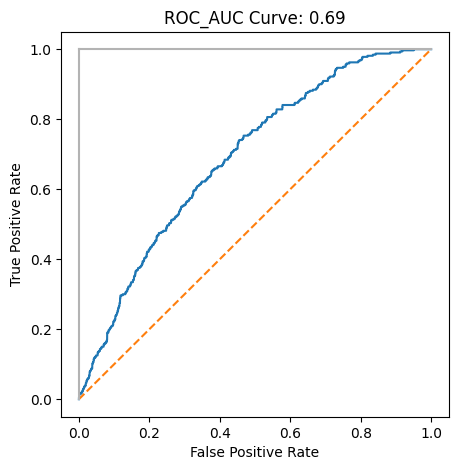

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.96      0.54      0.69      3336
 Bad Customer       0.13      0.74      0.23       320

     accuracy                           0.56      3656
    macro avg       0.55      0.64      0.46      3656
 weighted avg       0.88      0.56      0.65      3656

[[1818 1518]
 [  84  236]]
1818 1518 84 236


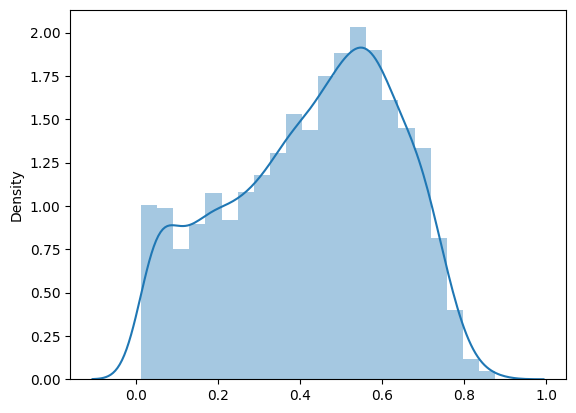

                                          variable  feature_importances
43                                             age                   87
48                                 loan_asset_cost                   80
44                             down_payment_amount                   76
52                                        dp_ratio                   50
45                                    total_income                   50
49                    res_years_at_current_address                   37
42                       res_years_at_current_city                   34
47                          number_of_installments                   21
41                  res_resident_status_grp_RENTED                   18
34                             res_city_grp_MUMBAI                   16
38                       res_state_grp_MAHARASHTRA                   13
7                           manufacturer_grp_HONDA                   12
25                          asset_model_grp_AVENIS              

In [8]:
#tuned
lgbc_ntc_vf = lgbc_model_builder3(boosting_type = 'gbdt',
        max_depth = 2,
        learning_rate = 0.21925421202433462,
        min_split_gain = 0.10144964926243934,
        num_leaves = 45,
        n_estimators = 319,
        min_child_samples = 221,
        subsample = 0.1959828624191452,
        reg_alpha = 13.828113525346753,
        reg_lambda = 8.84925020519195,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'
)

segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
LGBC_ohe_model_auc(X, lgbc_ntc_vf, segment)

[LightGBM] [Info] Number of positive: 824, number of negative: 8271
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1627
[LightGBM] [Info] Number of data points in the train set: 9095, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


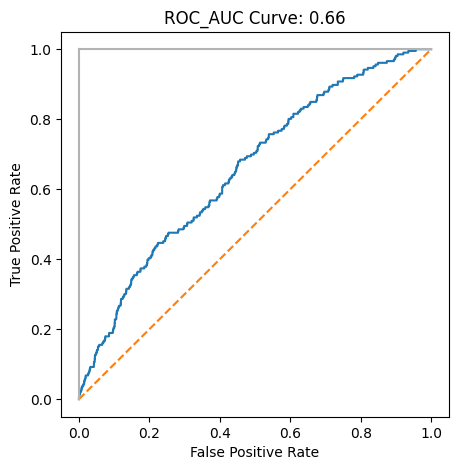

               precision    recall  f1-score   support

Good Customer       0.94      0.55      0.69      2068
 Bad Customer       0.13      0.67      0.22       206

     accuracy                           0.56      2274
    macro avg       0.54      0.61      0.46      2274
 weighted avg       0.87      0.56      0.65      2274

[[1133  935]
 [  67  139]]
1133 935 67 139


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


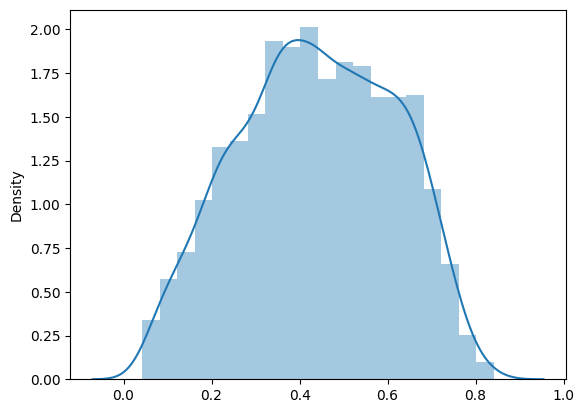

                                          variable  feature_importances
44                             down_payment_amount                   55
48                                 loan_asset_cost                   52
43                                             age                   45
45                                    total_income                   33
42                       res_years_at_current_city                   32
52                                        dp_ratio                   23
47                          number_of_installments                   18
38                       res_state_grp_MAHARASHTRA                   13
50                             years_in_occupation                   11
49                    res_years_at_current_address                   11
46                                   interest_rate                   11
0   occupation_type_SELF_EMPLOYED_NON_PROFESSIONAL                   10
34                             res_city_grp_MUMBAI              

In [9]:
#tuned
lgbc_low_CIBIL_vf = lgbc_model_builder3(boosting_type = 'gbdt',
        max_depth = 2,
        learning_rate = 0.21925421202433462,
        min_split_gain = 0.10144964926243934,
        num_leaves = 45,
        n_estimators = 319,
        min_child_samples = 221,
        subsample = 0.1959828624191452,
        reg_alpha = 13.828113525346753,
        reg_lambda = 8.84925020519195,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'
)
segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
LGBC_ohe_model_auc(X, lgbc_low_CIBIL_vf, segment)

[LightGBM] [Info] Number of positive: 347, number of negative: 5593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1615
[LightGBM] [Info] Number of data points in the train set: 5940, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


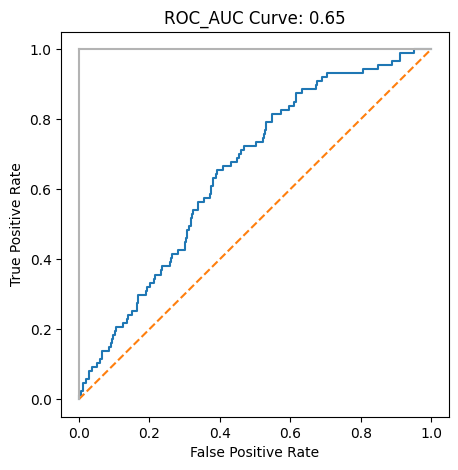

               precision    recall  f1-score   support

Good Customer       0.97      0.45      0.62      1398
 Bad Customer       0.08      0.80      0.15        87

     accuracy                           0.47      1485
    macro avg       0.53      0.63      0.38      1485
 weighted avg       0.92      0.47      0.59      1485

[[630 768]
 [ 17  70]]
630 768 17 70


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


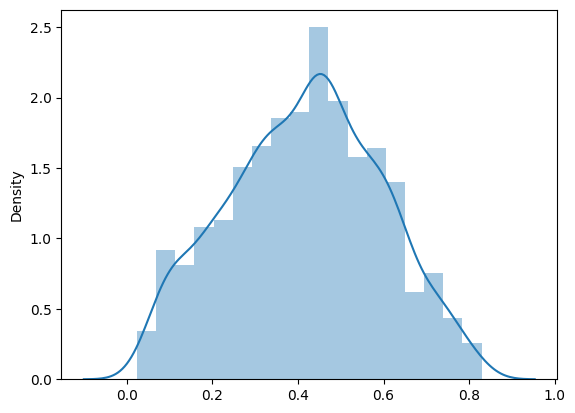

                                          variable  feature_importances
43                                             age                   78
48                                 loan_asset_cost                   55
44                             down_payment_amount                   48
52                                        dp_ratio                   44
45                                    total_income                   28
42                       res_years_at_current_city                   25
49                    res_years_at_current_address                   14
38                       res_state_grp_MAHARASHTRA                    9
46                                   interest_rate                    9
26                         asset_model_grp_BURGMAN                    9
3                           marital_status_MARRIED                    8
8                          manufacturer_grp_OTHERS                    7
41                  res_resident_status_grp_RENTED              

In [10]:
#tuned
lgbc_mid_CIBIL_vf = lgbc_model_builder3(boosting_type = 'gbdt',
        max_depth = 2,
        learning_rate = 0.21925421202433462,
        min_split_gain = 0.10144964926243934,
        num_leaves = 45,
        n_estimators = 319,
        min_child_samples = 221,
        subsample = 0.1959828624191452,
        reg_alpha = 13.828113525346753,
        reg_lambda = 8.84925020519195,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'
)
segment = 'mid_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
LGBC_ohe_model_auc(X, lgbc_mid_CIBIL_vf, segment)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 297, number of negative: 9790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 10087, number of used features: 47
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, da

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


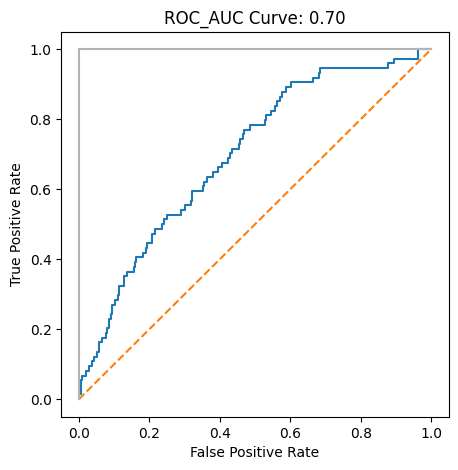

               precision    recall  f1-score   support

Good Customer       0.99      0.41      0.58      2448
 Bad Customer       0.04      0.88      0.08        74

     accuracy                           0.43      2522
    macro avg       0.52      0.65      0.33      2522
 weighted avg       0.96      0.43      0.57      2522

[[1011 1437]
 [   9   65]]
1011 1437 9 65


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_13256\983563860.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


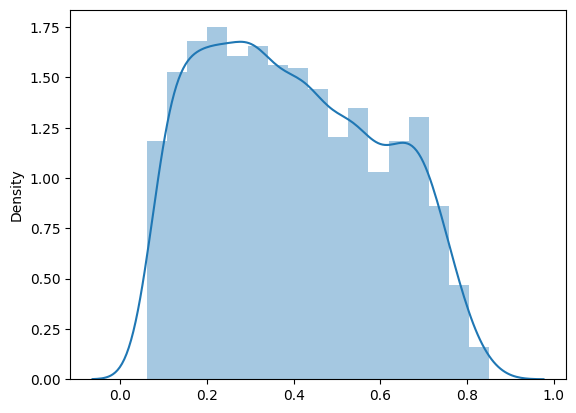

                          variable  feature_importances
43                             age                  457
52                        dp_ratio                  338
48                 loan_asset_cost                  337
44             down_payment_amount                  331
42       res_years_at_current_city                  318
49    res_years_at_current_address                  273
47          number_of_installments                  220
45                    total_income                  211
38       res_state_grp_MAHARASHTRA                  161
41  res_resident_status_grp_RENTED                  140
46                   interest_rate                  104
17               branch_grp_OTHERS                   76
7           manufacturer_grp_HONDA                   64
50             years_in_occupation                   45
37         res_state_grp_KARNATAKA                   42
6      nature_of_business_SERVICES                   39
5        nature_of_business_OTHERS              

In [11]:
#tuned
lgbc_high_CIBIL_vf = lgbc_model_builder3(boosting_type = 'gbdt',
        max_depth = 6,
        learning_rate = 0.01479540262121465,
        min_split_gain = 0.2199905443150214,
        num_leaves = 52,
        n_estimators = 463,
        min_child_samples = 328,
        subsample = 0.6174815096277165,
        reg_alpha = 0.011681487615214925,
        reg_lambda = 99.22115592912175,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'
)
segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
LGBC_ohe_model_auc(X, lgbc_high_CIBIL_vf, segment)